## Feature Selection in Machine Learning
We will be looking at the Friedman dataset from the sklearn library. It is a popular dataset used to compare feature selection methods for machine learning algorithms.

### Step 1: Defining a class for the problem

In [148]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import numpy as np

In [149]:
class Problem:
    
    def __init__(self,num_samples,num_features,noise,random_seed,test_split):
        
        self.num_samples = num_samples
        self.num_features = num_features
        self.noise = noise
        self.random_seed = random_seed
        self.test_split = test_split
        
        
        self.X, self.Y = datasets.make_friedman1(n_samples=self.num_samples,n_features=self.num_features,
                                                 noise=self.noise,random_state=self.random_seed)
        self.X_train, self.X_validation, self.Y_train, self.Y_validation = model_selection.train_test_split(self.X,self.Y,
                                                                    test_size = self.test_split,random_state=self.random_seed)
        
        self.regressor = ensemble.GradientBoostingRegressor(random_state=self.random_seed)
    
    def get_MSE(self,binary_list):
        
        zeroIndices = [i for i,n in enumerate(binary_list) if n==0]
        currentX_train = np.delete(self.X_train, zeroIndices, 1)
        currentX_validation = np.delete(self.X_validation, zeroIndices, 1)
        
        self.regressor.fit(currentX_train,self.Y_train)
        
        predictions = self.regressor.predict(currentX_validation)
        
        return metrics.mean_squared_error(self.Y_validation,predictions)

### Step 2: Problem representation and Parameters of Genetic algorithm

In [150]:
import random
from deap import tools
from deap import base
from deap import creator
import elitism
import seaborn as sns
import matplotlib.pyplot as plt

In [159]:
POPULATION_SIZE = 30
P_CROSSOVER = 0.9
P_MUTATION = 0.3
MAX_GENERATIONS = 30
HALL_OF_FAME_SIZE = 5
NUM_SAMPLES = 60
NUM_FEATURES = 15
NOISE = 1.0
TEST_SPLIT = 0.2
RANDOM_SEED = 42

In [161]:
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))
creator.create("individual",list,fitness = creator.FitnessMin)

In [162]:
friedman = Problem(NUM_SAMPLES,NUM_FEATURES,NOISE,RANDOM_SEED,TEST_SPLIT)

toolbox = base.Toolbox()

toolbox.register("zeroOrone",random.randint,0,1)

toolbox.register("individualCreator",tools.initRepeat,creator.individual,toolbox.zeroOrone,NUM_FEATURES)
toolbox.register("populationCreator",tools.initRepeat,list,toolbox.individualCreator)

toolbox.register("select",tools.selTournament,tournsize=2)
toolbox.register("mate",tools.cxTwoPoint)
toolbox.register("mutate",tools.mutFlipBit,indpb=1.0/NUM_FEATURES)

def get_MSE(individual):
    return friedman.get_MSE(individual),

toolbox.register("evaluate",get_MSE)

### Step 3: Genetic algorithm flow

gen	nevals	min    	avg    
0  	30    	12.2594	28.1585
1  	24    	9.82949	21.4425
2  	19    	9.82949	17.1355
3  	24    	9.82949	16.1701
4  	21    	9.82949	14.1769
5  	20    	9.82949	12.1201
6  	22    	9.82949	11.2709
7  	24    	7.45319	11.9821
8  	22    	7.26529	10.5643
9  	23    	7.26529	9.96037
10 	22    	6.70267	10.3836
11 	24    	6.70267	8.82774
12 	23    	6.70267	9.21107
13 	22    	6.70267	8.49222
14 	25    	6.70267	8.42527
15 	23    	6.70267	9.10437
16 	24    	6.70267	10.384 
17 	24    	6.70267	9.54936
18 	23    	6.70267	8.18406
19 	22    	6.70267	8.75601
20 	21    	6.70267	8.11227
21 	22    	6.70267	8.5577 
22 	23    	6.70267	7.61616
23 	24    	6.70267	7.44409
24 	24    	6.70267	8.44902
25 	20    	6.70267	7.50504
26 	23    	6.70267	8.0824 
27 	23    	6.70267	8.01326
28 	23    	6.70267	7.9705 
29 	20    	6.70267	7.75097
30 	21    	6.70267	7.68953
-- Best Ever Individual =  [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-- Best Ever Fitness =  6.702668910463276


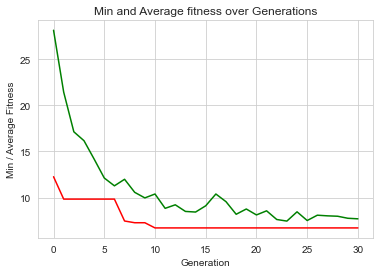

In [165]:
population = toolbox.populationCreator(POPULATION_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("min", np.min)
stats.register("avg", np.mean)

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
plt.show()